<a href="https://colab.research.google.com/github/MonkeyWrenchGang/2024_BAN7040/blob/main/3July2024_Decision_Trees_and_Random_Forest.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## Introduction to Decision Trees and Random Forests


- **Mike Ames**
- Email: amesam@wfu.edu
- Date: July 3, 2024

### Overview

This notebook's goal is to highlight how decision trees fit into the world of Random Forests. Trees are "weak-learners" sensitive to the sample of rows and columns, Forests exploit this by combining training trees on different samples and evaluating a sample of potential splits.  

### Structure

1. **Load Packages**: Import the necessary libraries and modules required for the analysis.
2. **Data Preparation**: Load and preprocess the dataset.
3. **Decision Trees**:
   - Train some Decision Trees
   - Building and Visualizing a Decision Tree
   - Evaluating the performance of the Decision Tree model
   - Look into how different samples influence different trees
4. **Random Forests**:
   - Build a Random Forests
   - Building and Visualizing trees from a Random Forest
   - Evaluating the performance of the Random Forest model


### Quote

> "And into the forest I go to lose my mind and find my soul." – John Muir



### Load Packages
-------



In [ ]:
from IPython.core.display import display, HTML
from IPython.display import clear_output
display(HTML("<style>.container { width:90% }</style>"))
import warnings
warnings.filterwarnings('ignore')
# ------------------------------------------------------------------

import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd

# -- sklearn modules
from sklearn.model_selection import train_test_split   #- partition train/test split
from sklearn.metrics import accuracy_score, precision_score, recall_score, classification_report #
from sklearn.tree import DecisionTreeClassifier        #- create a decison tree
from sklearn.ensemble import RandomForestClassifier    #- random forest classifier
from sklearn.tree import export_text                   #- export tree as text rules
from sklearn import tree

# -- visualize decision trees and decision surfaces
import graphviz

# -- need this to render charts in notebook --
%matplotlib inline

## 1. Stage
-----
import our dataset into a pandas dataframe


In [ ]:
df = pd.read_csv("https://raw.githubusercontent.com/MonkeyWrenchGang/HandsOnDataScience_Python/master/Week_2/data/churn.csv", na_values="?")
df.head()


,State,Account Length,Area Code,Phone,Int'l Plan,VMail Plan,VMail Message,Day Mins,Day Calls,Day Charge,...,Eve Calls,Eve Charge,Night Mins,Night Calls,Night Charge,Intl Mins,Intl Calls,Intl Charge,CustServ Calls,Churn?
0,KS,128,415,382-4657,no,yes,25,265.1,110,45.07,...,99,16.78,244.7,91,11.01,10.0,3,2.70,1,False.
1,OH,107,415,371-7191,no,yes,26,161.6,123,27.47,...,103,16.62,254.4,103,11.45,13.7,3,3.70,1,False.
2,NJ,137,415,358-1921,no,no,0,243.4,114,41.38,...,110,10.30,162.6,104,7.32,12.2,5,3.29,0,False.
3,OH,84,408,375-9999,yes,no,0,299.4,71,50.90,...,88,5.26,196.9,89,8.86,6.6,7,1.78,2,False.
4,OK,75,415,330-6626,yes,no,0,166.7,113,28.34,...,122,12.61,186.9,121,8.41,10.1,3,2.73,3,False.


## 2.  Clean up Column Names

*It's just not fun dealing with ill-formed columns*

- remove leading and trailing characters
- replace spaces with underscores _
- change case to lower case
- remove various special characters

In [ ]:
df.columns = ( df.columns
    .str.strip()
    .str.lower()
    .str.replace(' ', '_')
    .str.replace('-', '_')
    .str.replace('(', '')
    .str.replace(')', '')
    .str.replace('?', '')
    .str.replace('\'', '') # notice the backslash \ this is an escape character
)
df.columns

Index(['state', 'account_length', 'area_code', 'phone', 'intl_plan',
       'vmail_plan', 'vmail_message', 'day_mins', 'day_calls', 'day_charge',
       'eve_mins', 'eve_calls', 'eve_charge', 'night_mins', 'night_calls',
       'night_charge', 'intl_mins', 'intl_calls', 'intl_charge',
       'custserv_calls', 'churn'],
      dtype='object')

## 3. Describe data
### Check Target
-----
always start by understanding your target value


In [ ]:
df['churn'].value_counts()

churn
False.    2850
True.      483
Name: count, dtype: int64

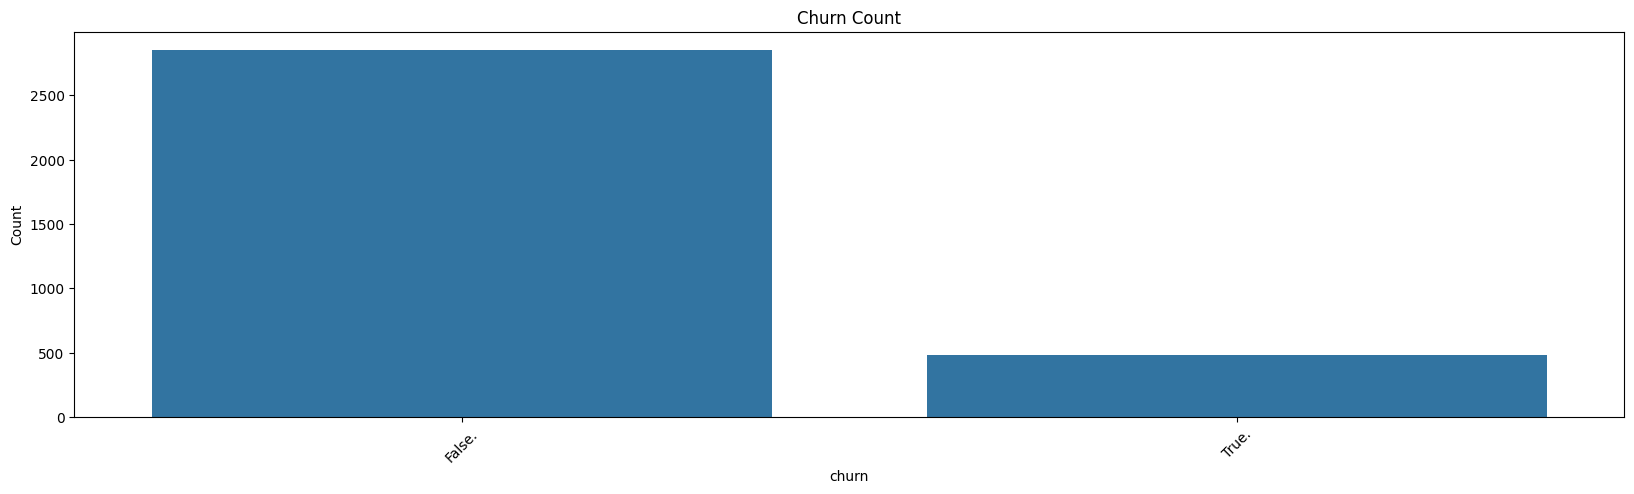

In [ ]:
plt.figure(figsize=(20,5))
# -- check out bottom
res1 = df.groupby(['churn']).agg({"account_length":"count"}).reset_index().rename(columns={"account_length":"count"})

sns.barplot(data=res1, x="churn", y="count")
plt.title('Churn Count' )
plt.ylabel('Count')
plt.xticks(rotation=45)
plt.xlabel("churn")
plt.show()


In [ ]:
numeric_features = ['account_length', 'area_code', 'vmail_message', 'day_mins', 'day_calls',
       'day_charge', 'eve_mins', 'eve_calls', 'eve_charge', 'night_mins',
       'night_calls', 'night_charge', 'intl_mins', 'intl_calls', 'intl_charge',
       'custserv_calls']

numeric_features

['account_length',
 'area_code',
 'vmail_message',
 'day_mins',
 'day_calls',
 'day_charge',
 'eve_mins',
 'eve_calls',
 'eve_charge',
 'night_mins',
 'night_calls',
 'night_charge',
 'intl_mins',
 'intl_calls',
 'intl_charge',
 'custserv_calls']

In [ ]:
categorical_features = ['state', 'intl_plan', 'vmail_plan']
categorical_features

['state', 'intl_plan', 'vmail_plan']

In [ ]:
df_prep = df.copy()
# 2. deal with nulls using fillna
df_prep[numeric_features]     = df_prep[numeric_features].fillna(-1)
df_prep[categorical_features] = df_prep[categorical_features].astype('str').fillna('missing')


In [ ]:
target = "churn"
df_prep = pd.get_dummies(df[[target] + numeric_features+categorical_features  ], columns=categorical_features)
df_prep.columns

feature_names = ['account_length', 'area_code', 'vmail_message', 'day_mins',
       'day_calls', 'day_charge', 'eve_mins', 'eve_calls', 'eve_charge',
       'night_mins', 'night_calls', 'night_charge', 'intl_mins', 'intl_calls',
       'intl_charge', 'custserv_calls', 'state_AK', 'state_AL', 'state_AR',
       'state_AZ', 'state_CA', 'state_CO', 'state_CT', 'state_DC', 'state_DE',
       'state_FL', 'state_GA', 'state_HI', 'state_IA', 'state_ID', 'state_IL',
       'state_IN', 'state_KS', 'state_KY', 'state_LA', 'state_MA', 'state_MD',
       'state_ME', 'state_MI', 'state_MN', 'state_MO', 'state_MS', 'state_MT',
       'state_NC', 'state_ND', 'state_NE', 'state_NH', 'state_NJ', 'state_NM',
       'state_NV', 'state_NY', 'state_OH', 'state_OK', 'state_OR', 'state_PA',
       'state_RI', 'state_SC', 'state_SD', 'state_TN', 'state_TX', 'state_UT',
       'state_VA', 'state_VT', 'state_WA', 'state_WI', 'state_WV', 'state_WY',
       'intl_plan_no', 'intl_plan_yes', 'vmail_plan_no', 'vmail_plan_yes']
df_prep.head()

,churn,account_length,area_code,vmail_message,day_mins,day_calls,day_charge,eve_mins,eve_calls,eve_charge,...,state_VA,state_VT,state_WA,state_WI,state_WV,state_WY,intl_plan_no,intl_plan_yes,vmail_plan_no,vmail_plan_yes
0,False.,128,415,25,265.1,110,45.07,197.4,99,16.78,...,False,False,False,False,False,False,True,False,False,True
1,False.,107,415,26,161.6,123,27.47,195.5,103,16.62,...,False,False,False,False,False,False,True,False,False,True
2,False.,137,415,0,243.4,114,41.38,121.2,110,10.30,...,False,False,False,False,False,False,True,False,True,False
3,False.,84,408,0,299.4,71,50.90,61.9,88,5.26,...,False,False,False,False,False,False,False,True,True,False
4,False.,75,415,0,166.7,113,28.34,148.3,122,12.61,...,False,False,False,False,False,False,False,True,True,False


In [ ]:
# make a Train Test Split
X_train, X_test, = train_test_split(df_prep, test_size=0.30)
print("train pct: {:2.2%}".format(X_train.shape[0]/df.shape[0]))
print("test  pct: {:2.2%}".format(X_test.shape[0]/df.shape[0]))

train pct: 70.00%
test  pct: 30.00%


## Simulate a Random Forest
----
The trick with random forest is to train each tree on a random set of features and a random sample of data, then vote your predictions. of course this is the simplest example, there is more to it behind the scenes but this shoudl give you an idea of what's going on.

1. sample a set of features
2. sample a set of data
3. train your tree
4. make predictonis
5. vote


In [ ]:
## Make three trees from random samples
import random

tree1_features = random.sample(feature_names,10)

tree1_sample = X_train[[target]+tree1_features].sample(frac=0.6, replace=True, random_state=123)
tree1 = tree.DecisionTreeClassifier(
                                    criterion='gini',
                                    #max_depth=10,
                                    min_samples_leaf=10)

tree1 = tree1.fit(tree1_sample[tree1_features], tree1_sample[target])
tree1



DecisionTreeClassifier(min_samples_leaf=10)

In [ ]:
tree2_features = random.sample(feature_names,10)
tree2_sample = X_train[[target]+tree2_features].sample(frac=0.6, replace=True, random_state=43)
tree2 = tree.DecisionTreeClassifier(
                                    criterion='gini',
                                    #max_depth=10,
                                    min_samples_leaf=10)

tree2 = tree2.fit(tree2_sample[tree2_features], tree2_sample[target])

tree2



DecisionTreeClassifier(min_samples_leaf=10)

In [ ]:
tree3_features = random.sample(feature_names,10)
tree3_sample = X_train[[target]+tree3_features].sample(frac=0.6, replace=True, random_state=234)
tree3 = tree.DecisionTreeClassifier(
                                    criterion='gini',
                                    #max_depth=10,
                                    min_samples_leaf=10)

tree3 = tree3.fit(tree3_sample[tree3_features], tree3_sample[target])
tree3

DecisionTreeClassifier(min_samples_leaf=10)

### Optionally you can visualize each tree : visualize a tree

```python
dot_data = tree.export_graphviz(tree1,
                                out_file=None,
                                feature_names=feature_names,
                                class_names = ["False.", "True."],
                                max_depth=3,
                                filled=True,
                                impurity=True,
                                proportion=True,
                                rounded=True,  
                                  special_characters=False)  
graph = graphviz.Source(dot_data)  
graph

```

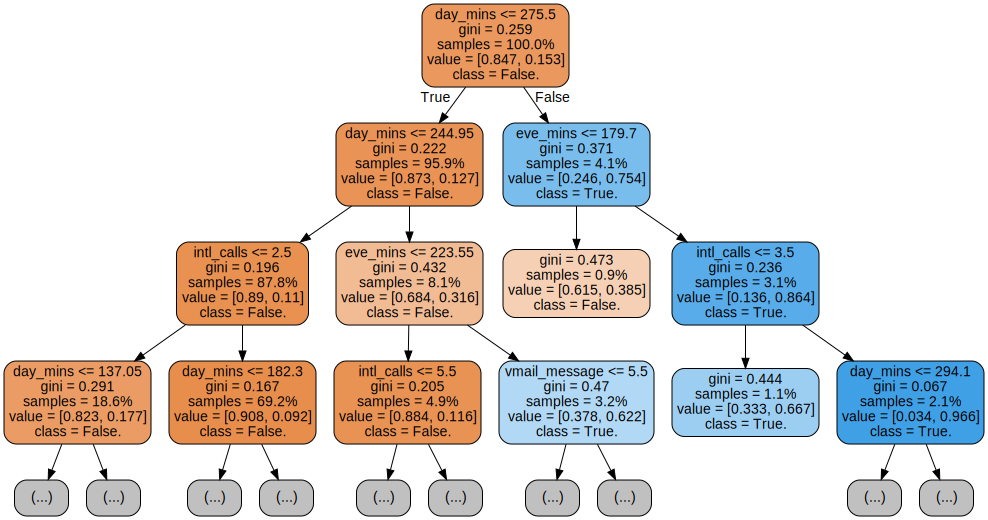

In [ ]:
dot_data = tree.export_graphviz(tree1,
                                out_file=None,
                                feature_names=tree1_features,
                                class_names = ["False.", "True."],
                                filled=True,
                                max_depth=3,
                                impurity=True,
                                proportion=True,
                                rounded=True,
                                special_characters=False)
graph = graphviz.Source(dot_data)
graph

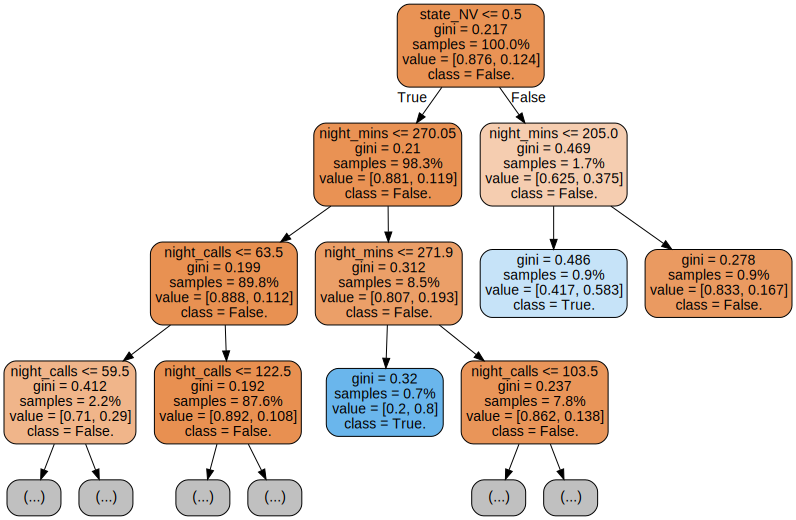

In [ ]:
dot_data = tree.export_graphviz(tree2,
                                out_file=None,
                                feature_names=tree2_features,
                                class_names = ["False.", "True."],
                                filled=True,
                                max_depth=3,
                                impurity=True,
                                proportion=True,
                                rounded=True,
                                  special_characters=False)
graph = graphviz.Source(dot_data)
graph

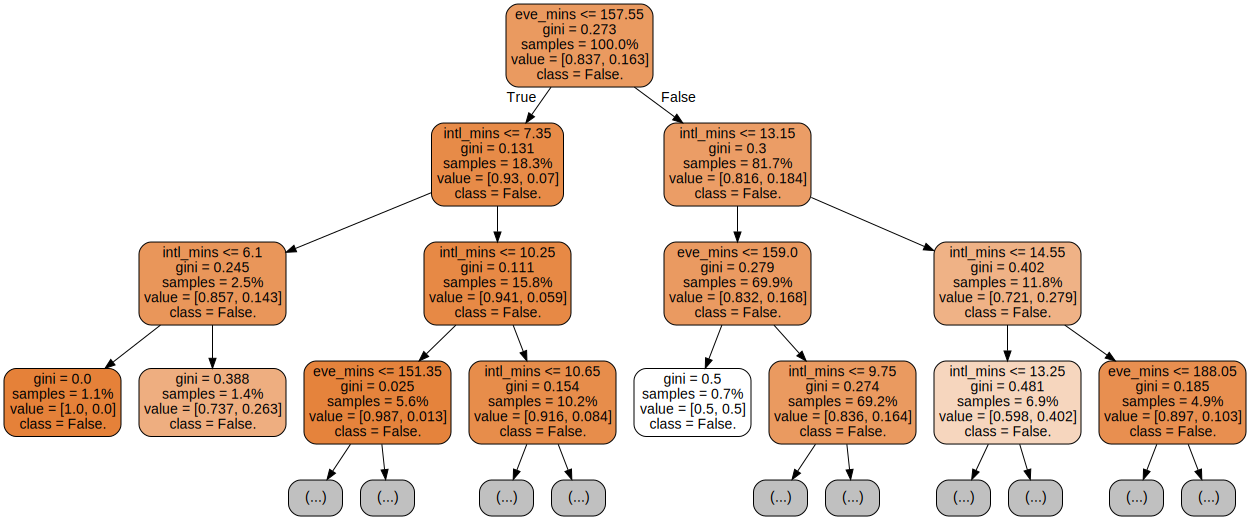

In [ ]:
dot_data = tree.export_graphviz(tree3,
                                out_file=None,
                                feature_names=tree3_features,
                                class_names = ["False.", "True."],
                                filled=True,
                                max_depth=3,
                                impurity=True,
                                proportion=True,
                                rounded=True,
                                  special_characters=False)
graph = graphviz.Source(dot_data)
graph

### Did you know you can Extract rules from tree!
---
Here is a handy function to extract business rules "export_text"

https://scikit-learn.org/stable/modules/generated/sklearn.tree.export_text.html


In [ ]:
r = export_text(tree3, feature_names=tree3_features, max_depth=3)
print(r)

|--- eve_mins <= 157.55
|   |--- intl_mins <= 7.35
|   |   |--- intl_mins <= 6.10
|   |   |   |--- class: False.
|   |   |--- intl_mins >  6.10
|   |   |   |--- class: False.
|   |--- intl_mins >  7.35
|   |   |--- intl_mins <= 10.25
|   |   |   |--- eve_mins <= 151.35
|   |   |   |   |--- class: False.
|   |   |   |--- eve_mins >  151.35
|   |   |   |   |--- truncated branch of depth 2
|   |   |--- intl_mins >  10.25
|   |   |   |--- intl_mins <= 10.65
|   |   |   |   |--- class: False.
|   |   |   |--- intl_mins >  10.65
|   |   |   |   |--- truncated branch of depth 6
|--- eve_mins >  157.55
|   |--- intl_mins <= 13.15
|   |   |--- eve_mins <= 159.00
|   |   |   |--- class: False.
|   |   |--- eve_mins >  159.00
|   |   |   |--- intl_mins <= 9.75
|   |   |   |   |--- truncated branch of depth 16
|   |   |   |--- intl_mins >  9.75
|   |   |   |   |--- truncated branch of depth 12
|   |--- intl_mins >  13.15
|   |   |--- intl_mins <= 14.55
|   |   |   |--- intl_mins <= 13.25
|   |   |

## 4 & 5 Random Forest works by Averaging or Voting on the Predictions
----

Here we make predictions for each tree, then we use mode to vote on the winning prediction.


In [ ]:
tree1.predict(tree1_sample[tree1_features])

array(['True.', 'False.', 'False.', ..., 'False.', 'False.', 'False.'],
      dtype=object)

In [ ]:
X_train["pred_tree1"] = tree1.predict(X_train[tree1_features])
X_train["pred_tree2"] = tree2.predict(X_train[tree2_features])
X_train["pred_tree3"] = tree3.predict(X_train[tree3_features])
# voting
X_train["pred_mode"] = X_train[["pred_tree1","pred_tree2","pred_tree3"]].mode(axis=1)

X_test["pred_tree1"] = tree1.predict(X_test[tree1_features])
X_test["pred_tree2"] = tree2.predict(X_test[tree2_features])
X_test["pred_tree3"] = tree3.predict(X_test[tree3_features])
# vote
X_test["pred_mode"] = X_test[["pred_tree1","pred_tree2","pred_tree3"]].mode(axis=1)


## Next we evaluate how we did

In [ ]:
accuracy_default = df['churn'].value_counts(normalize='True')[0]
print("Default Accuracy : {:2.2%}".format(accuracy_default))
for col in ["pred_tree1","pred_tree2","pred_tree3","pred_mode"]:
    accuracy_train = accuracy_score(X_train[target], X_train[col])
    accuracy_test = accuracy_score(X_test[target], X_test[col])
    print("model: {}".format(col))
    print("\t Train Accuracy   : {:2.2%}".format(accuracy_train))
    print("\t Test Accuracy    : {:2.2%}".format(accuracy_test))

Default Accuracy : 85.51%
model: pred_tree1
	 Train Accuracy   : 86.93%
	 Test Accuracy    : 85.10%
model: pred_tree2
	 Train Accuracy   : 84.01%
	 Test Accuracy    : 82.30%
model: pred_tree3
	 Train Accuracy   : 83.75%
	 Test Accuracy    : 81.80%
model: pred_mode
	 Train Accuracy   : 85.86%
	 Test Accuracy    : 85.20%


## RANDOM FOREST
----
IF one tree is good, then a hundred would be better right?

https://scikit-learn.org/stable/modules/generated/sklearn.ensemble.RandomForestClassifier.html



In [ ]:
rf_clf = RandomForestClassifier(n_estimators= 50)
rf_clf.fit(X_train[feature_names], X_train[target])

RandomForestClassifier(n_estimators=50)

In [ ]:
X_train["forest_pred"] = rf_clf.predict(X_train[feature_names])
X_test["forest_pred"] = rf_clf.predict(X_test[feature_names])

print("Default Accuracy : {:2.2%}".format(accuracy_default))
for col in ["forest_pred"]:
    accuracy_train = accuracy_score(X_train[target], X_train[col])
    accuracy_test = accuracy_score(X_test[target], X_test[col])
    print("model: {}".format(col))
    print("\t Train Accuracy   : {:2.2%}".format(accuracy_train))
    print("\t Test Accuracy    : {:2.2%}".format(accuracy_test))

Default Accuracy : 85.51%
model: forest_pred
	 Train Accuracy   : 100.00%
	 Test Accuracy    : 94.60%


## Prediction Probabilities
----
by default we use a score threshold of 0.5, meaning if the probabliy of churn is >= to 0.5 we classifiy this as churn=True. othewise churn=False.

as the predicted probably increases our precision increases but our recall decreases.

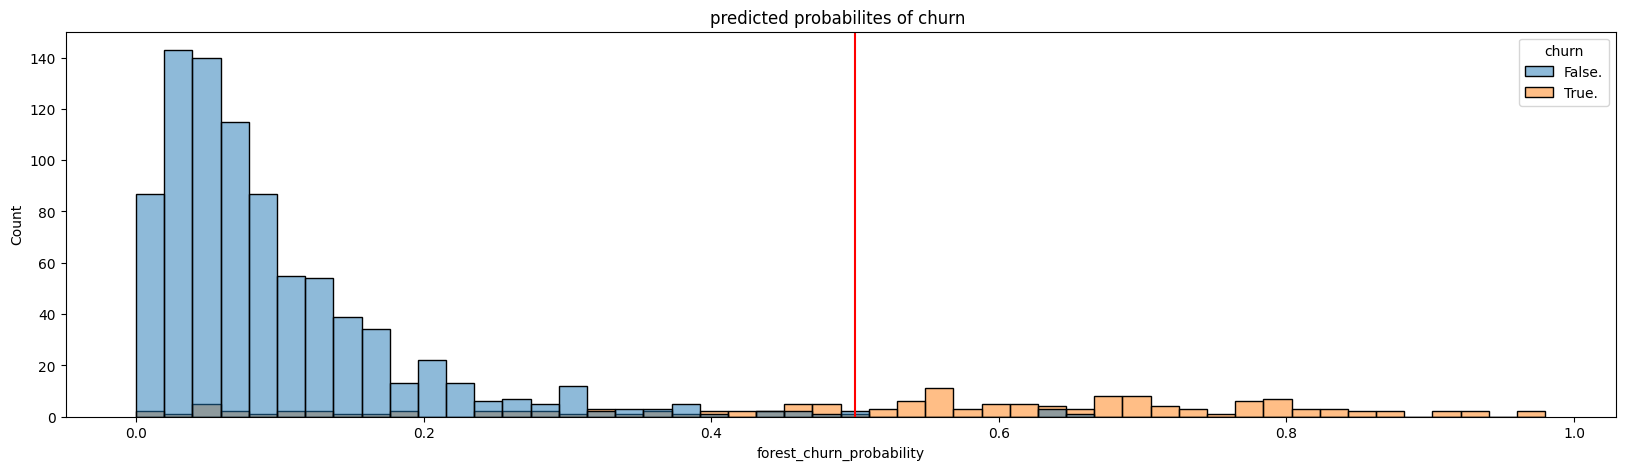

In [ ]:
X_test["forest_churn_probability"] = rf_clf.predict_proba(X_test[feature_names])[:,1]

#- plot
plt.figure(figsize=(20, 5))
sns.histplot(X_test,bins=50, x="forest_churn_probability",hue="churn")
plt.axvline(x=0.5, color="red")
plt.title("predicted probabilites of churn ")
plt.show()

In [ ]:
estimators = rf_clf.estimators_
estimators[0]

DecisionTreeClassifier(max_features='sqrt', random_state=2006628176)

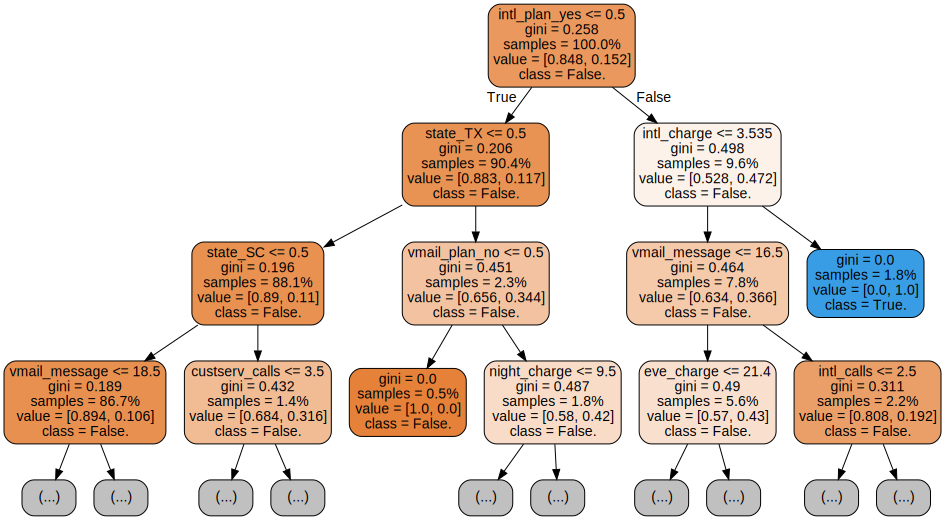

In [ ]:
# Extract the trees in the forest
estimators = rf_clf.estimators_

dot_data = tree.export_graphviz(estimators[10],
                                out_file=None,
                                feature_names=feature_names,
                                class_names = ["False.", "True."],
                                filled=True,
                                max_depth=3,
                                impurity=True,
                                proportion=True,
                                rounded=True,
                                  special_characters=False)
graph = graphviz.Source(dot_data)
graph



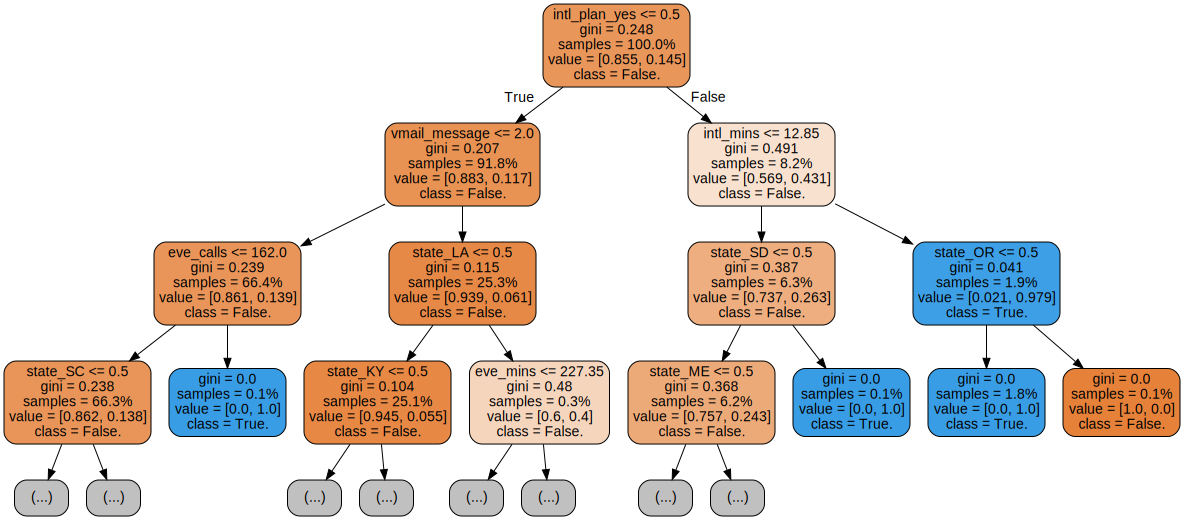

In [ ]:
dot_data = tree.export_graphviz(estimators[3],
                                out_file=None,
                                feature_names=feature_names,
                                class_names = ["False.", "True."],
                                filled=True,
                                max_depth=3,
                                impurity=True,
                                proportion=True,
                                rounded=True,
                                  special_characters=False)
graph = graphviz.Source(dot_data)
graph

